# Import Packages and Classifiers

In [1]:
#!pip install --user scikit-learn

In [2]:
#!pip install --user matplotlib

In [3]:
#!pip install --user pandas

In [4]:
#!pip install --user numpy

In [5]:
#!pip install --user seaborn

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import accuracy_score


In [36]:
import pandas as pd 
import numpy as np

https://scikit-learn.org/stable/modules/cross_validation.html

# Import Data 

In [44]:
hr_data = pd.read_csv("hr_data.csv")
bank_data = pd.read_csv("bank-marketing.csv")

# First Dataset 
https://www.kaggle.com/dhirajnirne/bank-marketing

## Prep Data for Modeling 

In [45]:
bank_data.columns

Index(['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'response'],
      dtype='object')

In [48]:
print(bank_data['loan'])

0         no
1         no
2        yes
3         no
4         no
        ... 
45206     no
45207     no
45208     no
45209     no
45210     no
Name: loan, Length: 45211, dtype: object


In [49]:
categorical_cols = ['age group', 'eligible', 'job', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'poutcome']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(bank_data[i].unique())
    bank_data[i] = le.transform(bank_data[i])

In [50]:
target = 'response'
cols = ['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

#splitn into training and testing data sets
train, test = train_test_split(bank_data, test_size=0.3)

## Decision Tree with Pruning 
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/

In [51]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities


In [54]:
len(alphas)

1127

In [64]:
from sklearn.metrics import accuracy_score
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = max_score if max_score < accuracy_score(test[target], y_test_pred) else max_score  


<AxesSubplot:>

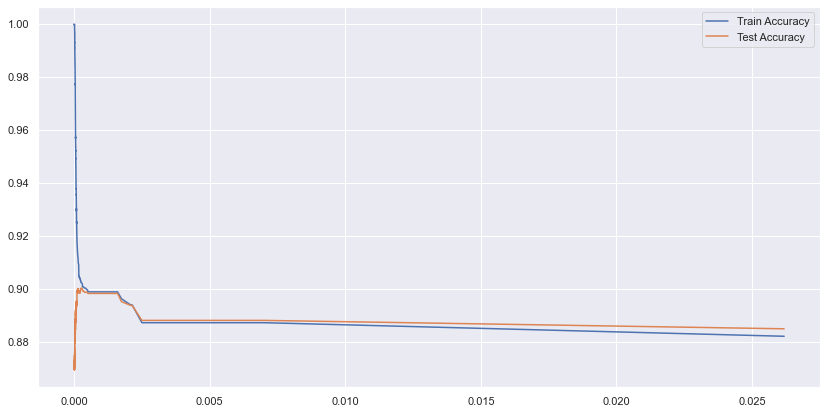

In [65]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy")
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy")

In [74]:

import time
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

In [93]:
final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, final_tree_runtime] ).T

## Neural Network
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [94]:
start_time = time.time()
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, nn_runtime] ).T

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Boosting 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.

In [95]:
start_time = time.time()

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(train[cols], train[target])
ada_runtime = time.time() - start_time 

ada_training_error = 1 - accuracy_score(train[target], ada.predict(train[cols]))
ada_error = 1 - accuracy_score(test[target], ada.predict(test[cols]))

ada_row = pd.DataFrame(['Ada Boost', ada_training_error, ada_error, ada_runtime] ).T

## Support Vector Machines 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py

In [96]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, clf_runtime] ).T

In [97]:
clf_row

,0,1,2,3
0,Support Vector Machine,0.090877,0.101592,13.491152


## K Nearest Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [98]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, neigh_runtime]).T 

In [99]:
neigh_row

,0,1,2,3
0,K Nearest Neighbor,0.076121,0.125922,0.008558


## Comp table

- Classifier Name 
- Training Error 
- Testing Error
- Training Time


In [103]:
final_df = neigh_row.append(clf_row).append(ada_row).append(nn_row).append(final_tree_row)
final_df.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Training Time']

In [104]:
final_df

,Classifier Name,Training Error,Testing Error,Training Time
0,K Nearest Neighbor,0.076121,0.125922,0.008558
0,Support Vector Machine,0.090877,0.101592,13.491152
0,Ada Boost,0.099599,0.100708,1.745234
0,Neural Network,0.117831,0.11501,0.141907
0,Decision Tree,0.117831,0.11501,0.194217


# Second Dataset   

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv

## Prep Data for Modeling 

In [61]:
hr_data.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [62]:
hr_data

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [27]:
categorical_cols = ['city', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(hr_data[i].unique())
    hr_data[i] = le.transform(hr_data[i])



In [29]:
target = 'target'
cols = ['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']

#splitn into training and testing data sets
train, test = train_test_split(hr_data, test_size=0.3)

## Decision Tree with Pruning 

<AxesSubplot:>

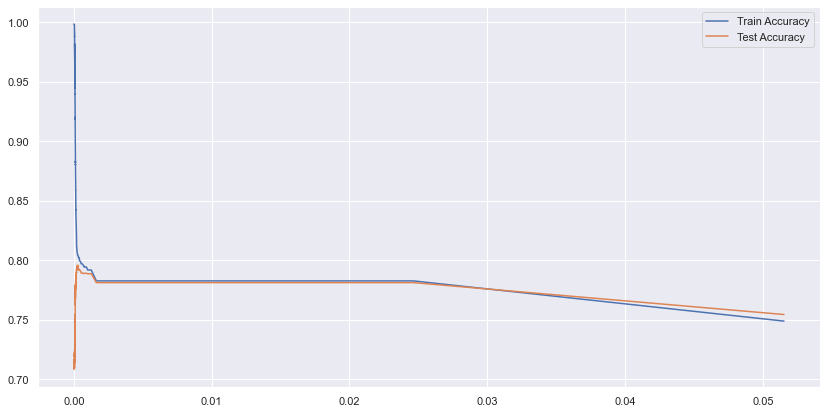

In [32]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities


accuracy_train, accuracy_test = [], []

for i in alphas:
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy")
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy")

## Neural Network

In [33]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])

accuracy_score(test[target], nn.predict(test[cols]))

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.7583507306889353

## Boosting 

In [34]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(train[cols], train[target])

accuracy_score(test[target], ada.predict(test[cols]))

0.7804453723034099

## Support Vector Machines 

In [35]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train[cols], train[target])

accuracy_score(test[target], clf.predict(test[cols]))

0.7800974251913709

## K Nearest Neighbors

In [36]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train[cols], train[target])

accuracy_score(test[target], neigh.predict(test[cols]))

0.7364300626304802